In [1]:
import numpy as np 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow import keras
import tensorflow as tf
from matplotlib.image import imread
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.applications import VGG16

Using TensorFlow backend.


In [2]:
# create a data generator
datagen = ImageDataGenerator(rescale=1./255)

In [3]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

total_train=1440
total_val=480
epochs_to_wait_for_improve = 2

In [4]:
# load and iterate training dataset
train_it = datagen.flow_from_directory('anuka1200/train/', class_mode='binary', batch_size=batch_size, shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))
# load and iterate validation dataset
val_it = datagen.flow_from_directory('anuka1200/validation/', class_mode='binary', batch_size=64, target_size=(IMG_HEIGHT, IMG_WIDTH))
# load and iterate test dataset
test_it = datagen.flow_from_directory('anuka1200/test/', class_mode='binary', batch_size=64, target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 1440 images belonging to 2 classes.
Found 480 images belonging to 2 classes.
Found 480 images belonging to 2 classes.


In [5]:
# confirm the iterator works
batchX, batchy = train_it.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Batch shape=(128, 150, 150, 3), min=0.000, max=0.980


In [6]:
# visualize images from batches
sample_training_images, _ = next(train_it)

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


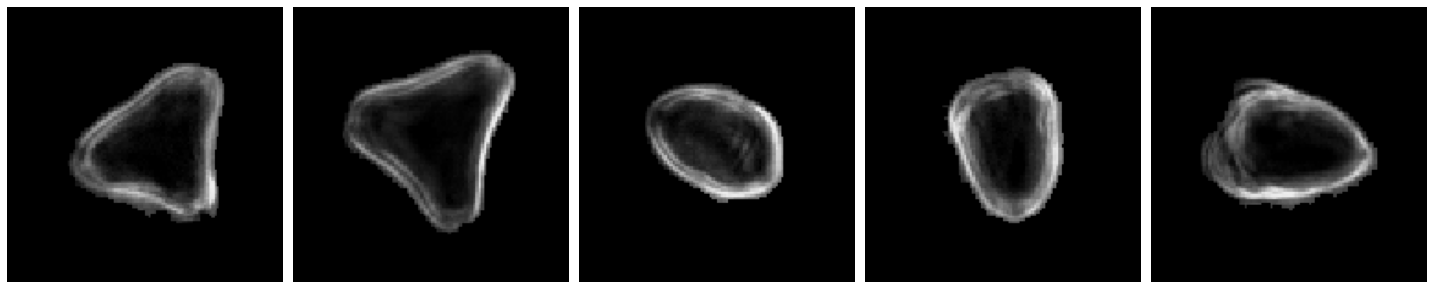

In [7]:
plotImages(sample_training_images[:5])

# Callbacks

In [8]:
class myCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True

# Instantiate callback
mycallback = myCallback()


early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                        patience=epochs_to_wait_for_improve,
                                                        verbose = 2)

# VGG16 Model

In [9]:
VGG16_MODEL=tf.keras.applications.VGG16(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                               include_top=False,
                                               weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
VGG16_MODEL.trainable=False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer =Dense(2, activation='softmax')

In [11]:
model_vgg = tf.keras.Sequential([
  VGG16_MODEL,
  global_average_layer,
  prediction_layer
])

model_vgg.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1026      
Total params: 14,715,714
Trainable params: 1,026
Non-trainable params: 14,714,688
_________________________________________________________________


In [12]:

history_vgg = model_vgg.fit_generator(
    train_it,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_it,
    validation_steps=total_val // batch_size,
    callbacks=[early_stopping_callback, mycallback]
) 

# It takes a while...

Epoch 1/15
12/12 [==============================] - 1372s 114s/step - loss: 0.7695 - acc: 0.4444 - val_loss: 0.7345 - val_acc: 0.4833
Epoch 2/15
12/12 [==============================] - 778s 65s/step - loss: 0.6912 - acc: 0.5576 - val_loss: 0.6628 - val_acc: 0.6396
Epoch 3/15
12/12 [==============================] - 806s 67s/step - loss: 0.6336 - acc: 0.7063 - val_loss: 0.6205 - val_acc: 0.6875
Epoch 4/15
12/12 [==============================] - 790s 66s/step - loss: 0.5877 - acc: 0.7347 - val_loss: 0.5853 - val_acc: 0.7042
Epoch 5/15
12/12 [==============================] - 748s 62s/step - loss: 0.5562 - acc: 0.7451 - val_loss: 0.5577 - val_acc: 0.7292
Epoch 6/15
12/12 [==============================] - 1092s 91s/step - loss: 0.5290 - acc: 0.7597 - val_loss: 0.5403 - val_acc: 0.7333
Epoch 7/15
12/12 [==============================] - 1241s 103s/step - loss: 0.5063 - acc: 0.7743 - val_loss: 0.5166 - val_acc: 0.7563
Epoch 8/15
12/12 [==============================] - 1208s 101s/step - l

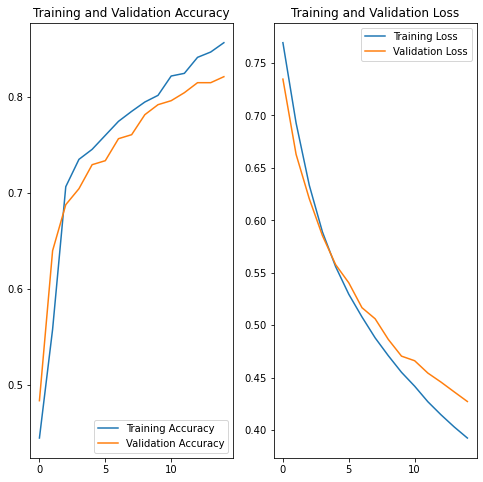

In [13]:
# Visualize training results
acc = history_vgg.history['acc']
val_acc = history_vgg.history['val_acc']

loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [14]:
test_loss, test_acc = model_vgg.evaluate(test_it, verbose=5)

print('\nTest accuracy:', test_acc)


# evaluate model
loss = model_vgg.evaluate_generator(test_it, steps=24)
print(loss)


Test accuracy: 0.83125
[0.4235653765499592, 0.83125]


In [15]:
import sklearn.metrics as metrics

Y_pred = model_vgg.predict(test_it, test_it.samples / batch_size)
val_preds = np.argmax(Y_pred, axis=1)

val_trues =val_it.classes
cm = metrics.confusion_matrix(val_trues, val_preds)
cm

array([[137, 103],
       [130, 110]], dtype=int64)